# Import Data

In [9]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [10]:
from Modules.dataEngineering import dataEngineering
dataEngineering = dataEngineering()

In [11]:
movies_item = ["MovieID", "Title", "Genres"]

users_item = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]

ratings_item = ["UserID", "MovieID", "Rating", "Timestamp"]

genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

movies = pd.DataFrame()
ratings = pd.DataFrame()
users = pd.DataFrame()

In [12]:
from_loc = f"Raw_Data\\ml-25M\\"

# movies = pd.read_csv(f'{from_loc}\\movies.dat', sep='::', header=None, names=movies_item, encoding='latin1')
# ratings = pd.read_csv(f'{from_loc}\\ratings.dat', sep='::', header=None, names=ratings_item, encoding='latin1')
# users = pd.read_csv(f'{from_loc}\\users.dat', sep='::', header=None, names=users_item, encoding='latin1')

In [13]:
movies = pd.read_csv(
    f"{from_loc}\\movies.csv",
    sep=",",
    header=None,
    names=movies_item,
    engine="python",
    skiprows=1,
)

full_movies = movies.copy()

ratings = pd.read_csv(
    f"{from_loc}\\ratings.csv",
    sep=",",
    header=None,
    names=ratings_item,
    engine="python",
    skiprows=1,
)

users = dataEngineering.loadUsers()['data']
# users   = pd.read_csv(f'{from_loc}\\users.csv', sep=',', header=None, names=users_item, engine='python', skiprows=1)

In [14]:
if "Years" not in movies.columns:
    # แยกปีออกจาก Title และ แปลง Genres เป็นรายการ
    movies["Years"] = movies["Title"].str.extract(r"\((\d{4})\)")[0]
    movies["Years"].fillna("0",inplace=True)
    movies["Years"] = movies["Years"].astype(int)

    # movies['Genres'] = movies['Genres'].str.split('|')

    # ลบวงเล็บและปีออกจาก Title
    movies["Title"] = movies["Title"].str.split("(").str[0]
    movies["Title"] = movies["Title"].str.rstrip()

    ratings = ratings.rename({"Rating": "userRating"}, axis="columns")
    ratings["Years"] = pd.to_datetime(ratings["Timestamp"], unit="s").dt.year
    ratings['Timestamp'] = pd.to_datetime(ratings['Timestamp'], unit="s").dt.date

In [16]:
print("Check Null: Movie Title:" )
display(movies[movies["Title"] == ""])


for index in list(movies[movies["Title"] == ""].index):
    movies.at[index, "Title"] = full_movies.at[index, "Title"]

movies[movies["Title"] == ""]

สร้างข้อมูล โดยใช้ Faker เป็นการสุ่มสร้างข้อมูล


In [19]:
# สร้างข้อมูลผู้ใช้แบบสุ่ม
if users is None:
    from faker import Faker
    from datetime import date
    import random

    fake = Faker("th_TH")
    userIDs = ratings["UserID"].unique()

    dic_users = {
        "UserID": [],
        "Username": [],
        "Email": [],
        "Password": [],
        "Gender": [],
        "Age": [],
    }

    for i in userIDs:
        profile = fake.simple_profile()

        userName = profile["username"]
        email = profile["mail"]
        password = "12345678"  # password = fake.password()
        gender = profile["sex"]
        age = random.randrange(12, 60)

        dic_users["UserID"].append(int(i))
        dic_users["Username"].append(userName)
        dic_users["Email"].append(email)
        dic_users["Password"].append(password)
        dic_users["Gender"].append(gender)
        dic_users["Age"].append(age)

    users = pd.DataFrame(
        dic_users, columns=["UserID", "Username", "Email", "Password", "Gender", "Age"]
    )

In [20]:
def display_pd(df_clean):
    display(df_clean.head(5), df_clean.shape)

def check_Years(df_clean):
    movie_by_years_count = (
        df_clean.groupby("Years")
        .count()["MovieID"]
        .sort_values(ascending=True)
        .reset_index()
    )
    movie_by_years_count.rename(columns={"MovieID": "No-of-Years"}, inplace=True)

    return movie_by_years_count.describe()

# Data Filtering

In [207]:
year_now = 2019  # 2023

f_movie_count = 1000
rating_years = 6
last_login = 1

### 1. ภาพยนคร์เรื่องนั้นต้องมีการให้คะแนนเรตติ้งมากกว่า `1,000` ครั้ง


In [208]:
movies_ratings_count = (
    ratings[["MovieID", "UserID"]].groupby("MovieID").count()["UserID"].reset_index()
)
movies_ratings_count.rename(columns={"UserID": "No-of-Movie-Ratings"}, inplace=True)

df_movies_ratings = movies_ratings_count[
    movies_ratings_count["No-of-Movie-Ratings"] >= f_movie_count
]
if "No-of-Movie-Ratings" in df_movies_ratings.columns:
    df_movies_ratings.drop(columns=["No-of-Movie-Ratings"], inplace=True)

Before Count Movie: 62423
After  Count Movie: 3794


In [209]:
df_clean_movies = pd.merge(df_movies_ratings, movies, on="MovieID")

display(check_Years(df_clean_movies))
display_pd(df_clean_movies)

,Years,No-of-Years
count,99.000000,99.000000
mean,1950.535354,38.323232
std,200.061639,44.493024
min,0.000000,1.000000
25%,1945.500000,5.000000
50%,1970.000000,14.000000
75%,1994.500000,62.500000
max,2019.000000,164.000000


,MovieID,Title,Genres,Years
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


(3794, 4)

In [210]:
df_movie_ratings = pd.merge(ratings, df_clean_movies["MovieID"], on="MovieID")
# display(filtered_ratings.head(5), filtered_ratings.shape)

### 2. คะแนนเรตติ้งที่อยู่ในช่วงไม่เกิน `6` ปี


In [211]:
df_ratings_years = df_movie_ratings[year_now - df_movie_ratings["Years"] < rating_years]

display_pd(df_ratings_years)

,UserID,MovieID,userRating,Timestamp,Years
1,3,296,5.0,2015-08-13,2015
2,4,296,4.0,2019-11-16,2019
9,14,296,5.0,2017-09-23,2017
12,19,296,3.5,2016-06-23,2016
19,33,296,4.5,2019-03-17,2019


(6790572, 5)

### 3. ผู้ใช้งานต้องมีการให้คะแนนเรตติ้งล่าสุดไม่เกิน `1` ปี


In [212]:
df_last_ratings = df_ratings_years.groupby("UserID").max()["Years"].reset_index()
df_last_ratings.rename(columns={"Years": "Last-of-Years"}, inplace=True)
df_last_ratings.describe()

,UserID,Last-of-Years
count,48952.000000,48952.000000
mean,81249.899882,2016.801173
std,46993.879990,1.607167
min,3.000000,2014.000000
25%,40342.500000,2015.000000
50%,81139.500000,2017.000000
75%,122180.250000,2018.000000
max,162538.000000,2019.000000


In [213]:
df_clean_last_ratings = df_last_ratings[year_now - df_last_ratings["Last-of-Years"] < last_login]
if "Last-of-Years" in df_clean_last_ratings.columns:
    df_clean_last_ratings.drop(columns=["Last-of-Years"], inplace=True)

In [214]:
filtered_ratings = pd.merge(df_ratings_years, df_clean_last_ratings, on="UserID")

if "Timestamp" in filtered_ratings.columns:
    # filtered_ratings.drop(columns=['Years'], inplace=True)
    filtered_ratings.drop(columns=["Timestamp"], inplace=True)

display_pd(filtered_ratings)

,UserID,MovieID,userRating,Years
0,3,296,5.0,2015
1,3,1217,5.0,2015
2,3,1653,5.0,2015
3,3,4308,3.0,2015
4,3,5952,4.0,2015


(2247560, 4)

# Result


In [235]:
import matplotlib.pyplot as plt

def change_format(n):
    return '{:,}'.format(n)

def BeforeAfter(before, after):
    display(after.head(5))
    print("Before :", change_format(before.shape[0]))
    print("After  :", change_format(after.shape[0]))

def plot_graph_by_year(freq_by_year, title = 'Show Frequency Movies By Years', y_name='Frequency Year', x_name='Years'):
    freq_by_year.sort_index(inplace=True)

    plt.figure(figsize=(10, 5))
    plt.plot(freq_by_year.index, freq_by_year.values)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(title)
    plt.show()

### Movie


In [237]:
filtered_movies = pd.DataFrame(
    filtered_ratings["MovieID"].unique(), columns=["MovieID"]
)

df_movies = pd.merge(movies, filtered_movies, on="MovieID")
BeforeAfter(movies, df_movies)


,MovieID,Title,Genres,Years
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


Before : 62,423
After  : 3,794


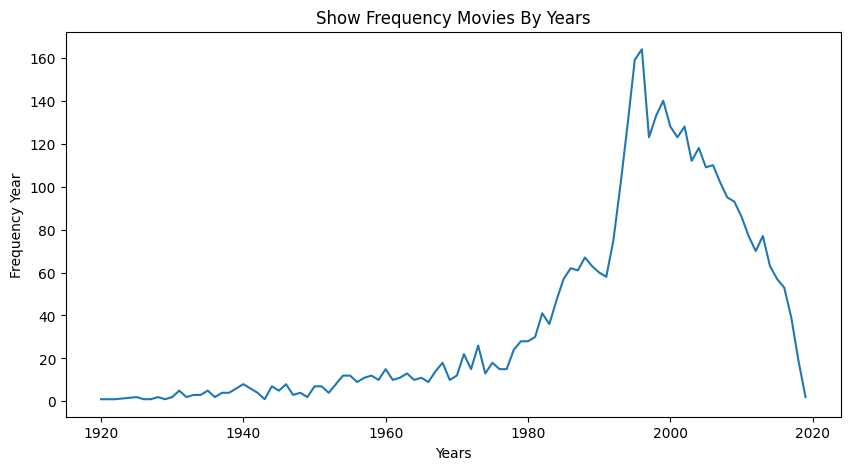

In [238]:
plot_graph_by_year(df_movies[df_movies['Years'] != 0].groupby("Years").count()["MovieID"])

### User


In [239]:
BeforeAfter(users, users)

,UserID,Username,Email,Password,Gender,Age
0,1,praedim56,rphasphngsthngpaaknam@outlook.com,12345678,M,50
1,2,thitikulbawephuuen,phaadiila59@protonmail.com,12345678,F,15
2,3,mnaathaedcha,mattikaa51@gmail.com,12345678,F,47
3,4,qdwngosn,fngaamphiechsth@ymail.com,12345678,F,13
4,5,sthungengin,nathcchsakditantraacchin@outlook.com,12345678,F,37


Before : 162,541
After  : 162,541


### Active Users


In [240]:
active_user = pd.DataFrame(
    {"UserID": filtered_ratings["UserID"].unique()}, columns=["UserID"]
)
active_user = df_users.merge(active_user, on="UserID", how="inner")

BeforeAfter(df_users, active_user)

,UserID,Username,Email,Password,Gender,Age
0,3,mnaathaedcha,mattikaa51@gmail.com,12345678,F,47
1,4,qdwngosn,fngaamphiechsth@ymail.com,12345678,F,13
2,33,nkhrethphpracchin,lthngyuu@ymail.com,12345678,M,37
3,63,thuupawiorcchnthiwatr,vthrrmemthaa@protonmail.com,12345678,M,51
4,76,nilwrrnkngsin,phimphkaantdisdain@kon.in.th,12345678,M,30


Before : 162,541
After  : 10,445


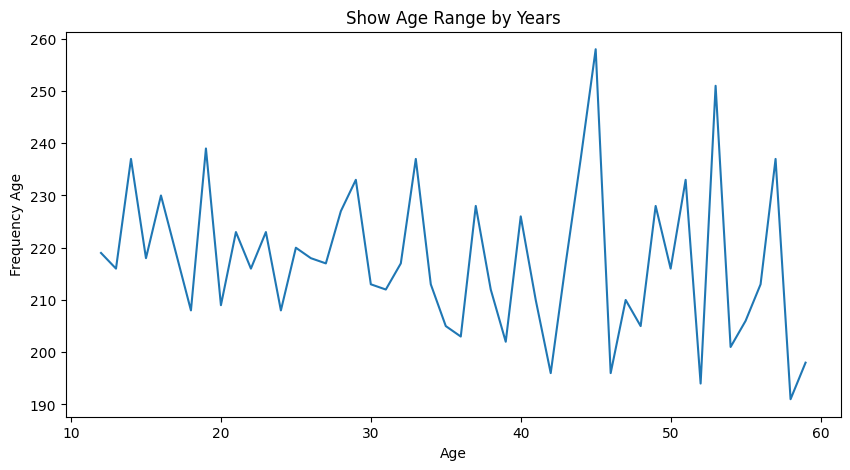

In [241]:
plot_graph_by_year(
    active_user[active_user['Age'] != 0].groupby("Age").count()["UserID"],
    title = 'Show Age Range by Years', y_name = 'Frequency Age', x_name='Age'
)

### Rating


In [242]:
df_ratings = filtered_ratings[["UserID", "MovieID", "userRating", "Years"]].copy()

BeforeAfter(ratings, df_ratings)

,UserID,MovieID,userRating,Years
0,3,296,5.0,2015
1,3,1217,5.0,2015
2,3,1653,5.0,2015
3,3,4308,3.0,2015
4,3,5952,4.0,2015


Before : 25,000,095
After  : 2,247,560


# Save File to database SQL


In [243]:
import sqlite3
import os

def saveDatabase(table, df, path = '\input'):
    path += "\\" + table + ".db"

    # Check มี File นั้นหรือไม่
    key = os.path.exists(path)
    if key:
        os.remove(path)
    conn = sqlite3.connect(path)
    df.to_sql(table, conn, if_exists="replace", index=False)
    conn.close()
    print(f"Save: {table}")

In [244]:
# saveDatabase('movies', df_movies)
# saveDatabase('users', df_users)
# saveDatabase('ratings', df_ratings)